# Sensitivity analysis

In [1]:
import os
import sys

import cartopy.crs as ccrs
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from h2ss import capacity as cap
from h2ss import data as rd
from h2ss import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Read data layers

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [4]:
# exploration wells
_, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

# wind farms
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

# frequent shipping routes
_, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

# shipwrecks
_, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

# subsea cables
_, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

# distance from salt formation edge
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Sensitivity

In [5]:
def sensitivity_calc(
    var_list,
    quantity,
    height_base,
    min_depth_base,
    max_depth_base,
):
    """Calculate sensitivity"""
    capacity_list = []
    for x in var_list:
        if quantity == "height":
            zones, zds = fns.zones_of_interest(
                dat_xr=ds,
                constraints={
                    "height": x,
                    "min_depth": min_depth_base,
                    "max_depth": max_depth_base,
                },
            )
            height_list = [
                [85, 155, 311][
                    np.searchsorted([85, 155, 311], [x], side="right")[0] - 1
                ]
            ]
        elif quantity == "min_depth":
            zones, zds = fns.zones_of_interest(
                dat_xr=ds,
                constraints={
                    "height": height_base,
                    "min_depth": x,
                    "max_depth": max_depth_base,
                },
            )
            height_list = [height_base]
        elif quantity == "max_depth":
            zones, zds = fns.zones_of_interest(
                dat_xr=ds,
                constraints={
                    "height": height_base,
                    "min_depth": min_depth_base,
                    "max_depth": x,
                },
            )
            height_list = [height_base]
        elif quantity == "base":
            zones, zds = fns.zones_of_interest(
                dat_xr=ds,
                constraints={
                    "height": height_base,
                    "min_depth": min_depth_base,
                    "max_depth": max_depth_base,
                },
            )
            height_list = [height_base]
        caverns, _ = fns.generate_caverns_with_constraints(
            zones_gdf=zones,
            zones_ds=zds,
            dat_extent=extent,
            exclusions={
                "wells": wells_b,
                "wind_farms": wind_farms,
                "shipwrecks": shipwrecks_b,
                "shipping": shipping_b,
                "cables": cables_b,
                "edge": edge_buffer,
            },
        )
        caverns = fns.label_caverns(
            cavern_df=caverns,
            heights=height_list,
            depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
        )
        caverns = cap.calculate_capacity_dataframe(cavern_df=caverns)
        capacity_list.append(caverns[["capacity"]].sum().iloc[0])
    return capacity_list

In [6]:
class HiddenPrints:
    """Suppress print statements: https://stackoverflow.com/a/45669280"""
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, "w")

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [7]:
def sensitivity(height_base=155, min_depth_base=1000, max_depth_base=1500):
    """Calculate sensitivity"""
    sdf1 = {}

    # base case
    with HiddenPrints():
        base_case = sensitivity_calc(
            var_list=[height_base],
            quantity="base",
            height_base=height_base,
            min_depth_base=min_depth_base,
            max_depth_base=max_depth_base,
        )[0]

    # heights = [85 + 226 / 50 * n for n in range(51)]
    depth_min = [500 + 10 * n for n in range(51)]
    depth_max = [1500 + 10 * n for n in range(51)]

    for x, y in zip([depth_max, depth_min], ["max_depth", "min_depth"]):
        with HiddenPrints():
            capacity_list = sensitivity_calc(
                var_list=x,
                quantity=y,
                height_base=height_base,
                min_depth_base=min_depth_base,
                max_depth_base=max_depth_base,
            )

        sdf1[y] = pd.DataFrame({"capacity": capacity_list, y: x})

        # percentage change
        sdf1[y]["diff_capacity"] = (
            (sdf1[y]["capacity"] - base_case) / base_case * 100
        )

    return sdf1

In [8]:
sdf = sensitivity()

In [9]:
for key in sdf.keys():
    print(key)
    print(sdf[key].describe())

max_depth
           capacity    max_depth  diff_capacity
count     51.000000    51.000000      51.000000
mean   44077.698966  1750.000000      29.420779
std     6383.818183   148.660687      18.744144
min    34057.667816  1500.000000       0.000000
25%    38501.565857  1625.000000      13.048157
50%    42737.268959  1750.000000      25.485013
75%    50285.284619  1875.000000      47.647469
max    54267.475851  2000.000000      59.339965
min_depth
           capacity    min_depth  diff_capacity
count     51.000000    51.000000      51.000000
mean   46402.731092   750.000000      36.247530
std     6627.709720   148.660687      19.460257
min    34057.667816   500.000000       0.000000
25%    40908.189488   625.000000      20.114477
50%    47181.784261   750.000000      38.534983
75%    52320.790198   875.000000      53.624113
max    56062.682315  1000.000000      64.611043


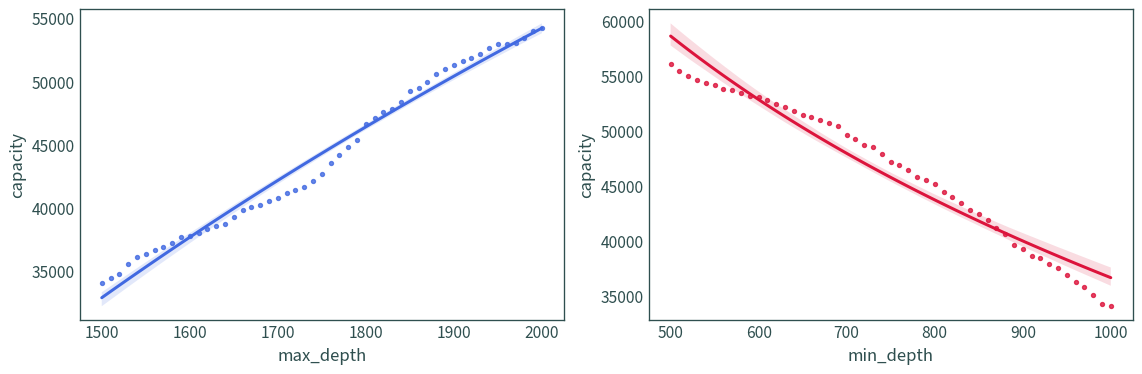

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for (n, key), c in zip(
    enumerate(sdf.keys()), ["royalblue", "crimson", "seagreen"]
):
    sns.regplot(
        sdf[key],
        x=key,
        y="capacity",
        logx=True,
        ax=axes[n],
        marker=".",
        color=c,
    )
plt.tight_layout()
plt.show()

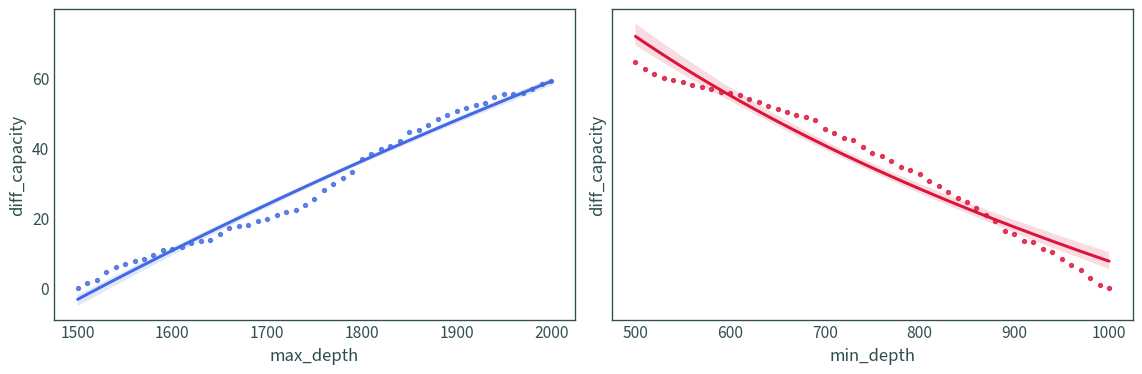

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for (n, key), c in zip(
    enumerate(sdf.keys()), ["royalblue", "crimson", "seagreen"]
):
    sns.regplot(
        sdf[key],
        x=key,
        y="diff_capacity",
        logx=True,
        ax=axes[n],
        marker=".",
        color=c,
    )
# plt.ylim(-150, 150)
plt.tight_layout()
plt.show()